In [3]:
import pandas as pd

df = pd.read_csv('part1/data.csv')
df = df.dropna(subset=['value'])
df = df.drop(["Unnamed: 0"], axis=1)
df.columns = ['YEAR', 'MONTH', 'DAY','City','Type','Value']

In [4]:
df_w = pd.read_csv('Data/average_daily_weather.csv')
#df = df.dropna(subset=['value'])
#df = df.drop(["Unnamed: 0"], axis=1)

In [5]:
merged_df = pd.merge(df, df_w, on=['YEAR','MONTH','DAY','City'], how='inner')
merged_df
merged_df = merged_df.drop(["Humidity"], axis=1)
merged_df = merged_df.dropna()
merged_df

,YEAR,MONTH,DAY,City,Type,Value,Temperature,Wind
0,2019,1,8,Warszawa,PM10,52.78,-2.6,3.0
1,2019,1,8,Warszawa,"PM2,5",35.56,-2.6,3.0
2,2019,1,9,Warszawa,PM10,43.53,-3.1,0.0
3,2019,1,9,Warszawa,"PM2,5",38.64,-3.1,0.0
4,2019,1,10,Warszawa,PM10,46.63,-6.8,2.5
...,...,...,...,...,...,...,...,...
24470,2021,2,14,Katowice,"PM2,5",33.20,-5.3,0.0
24471,2021,2,15,Katowice,"PM2,5",59.70,-7.1,1.5
24472,2021,2,16,Katowice,"PM2,5",54.90,-4.2,0.0
24473,2021,2,17,Katowice,"PM2,5",33.50,1.1,3.7


In [6]:
PM10 = merged_df[merged_df['Type']=='PM10']

In [7]:
# Stworzenie słownika mapującego nazwy miast na liczby całkowite
city_dict = {city: i+1 for i, city in enumerate(PM10['City'].unique())}
PM10.loc[:, 'City'] = PM10['City'].replace(city_dict)
# Zamiana nazw miast na odpowiadające im liczby całkowite
PM10

c:\users\artur\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,YEAR,MONTH,DAY,City,Type,Value,Temperature,Wind
0,2019,1,8,1,PM10,52.78,-2.6,3.0
2,2019,1,9,1,PM10,43.53,-3.1,0.0
4,2019,1,10,1,PM10,46.63,-6.8,2.5
6,2019,1,11,1,PM10,53.70,-7.1,0.0
8,2019,1,12,1,PM10,25.76,0.9,2.7
...,...,...,...,...,...,...,...,...
24405,2021,12,25,5,PM10,28.00,-4.1,0.0
24407,2021,12,28,5,PM10,42.30,-4.7,2.9
24409,2021,12,29,5,PM10,45.60,-0.7,0.0
24411,2021,12,30,5,PM10,15.70,4.6,4.6


In [8]:
city_dict

{'Warszawa': 1, 'Wrocław': 2, 'Gdańsk': 3, 'Kraków': 4, 'Katowice': 5}

In [9]:
PM10_train = PM10[PM10['YEAR']<=2018]
PM10_test = PM10[PM10['YEAR']==2019]

In [10]:
from sklearn.ensemble import RandomForestRegressor

X=PM10_train[['City','Temperature','Wind']]
y=PM10_train['Value']


In [11]:
X_test=PM10_test[['City','Temperature','Wind']]
y_test=PM10_test['Value']

In [12]:
clf = RandomForestRegressor()
clf.fit(X, y)

RandomForestRegressor()

In [14]:
y_predicted=clf.predict(X_test)

# Sprawdzenie trafności przewidywań modelu

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# błąd średniokwadratowy (mean squared error - MSE)
mse = mean_squared_error(y_test, y_predicted)
print("MSE:", mse)
print("MSE sqrt:", np.sqrt(mse))

#błąd średniowzględny (mean absolute error - MAE)
mae = mean_absolute_error(y_test, y_predicted)
print("MAE:", mae)

#współczynnik determinacji R2
r2 = r2_score(y_test, y_predicted)
print("R2:", r2)

MSE: 426.8854496091077
MSE sqrt: 20.66120639287812
MAE: 14.555900328786755
R2: 0.17726303253443354


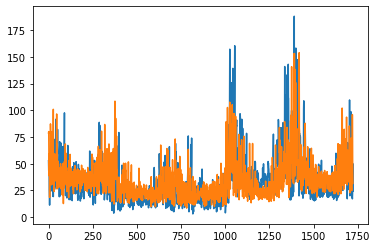

In [18]:
#Na wykresie true vs predicted
import matplotlib.pyplot as plt

# wykres wartości rzeczywistych i predykowanych
plt.plot(y_test.values, label='Rzeczywiste')
plt.plot(y_predicted)

In [19]:
y_test.values

array([52.78, 43.53, 46.63, ..., 22.  , 50.2 , 24.2 ])

In [20]:
len(y_predicted)

1724

In [21]:
#Mean Absolute Percentage Error (MAPE)
import numpy as np
MAPE = (1/len(y_test)) * np.sum(abs((y_test - y_predicted)/y_test)) * 100
MAPE

55.229802117324

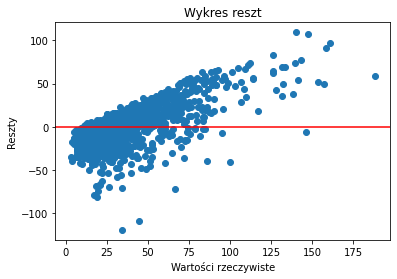

In [22]:
residuals = y_test - y_predicted

# Wygenerowanie wykresu reszt
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Wykres reszt')
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Reszty')
plt.show()